## Example: 
Design a **warped low pass filter** with cutoﬀ frequency of $0.05 * pi$ (pi is the Nyquist frequency). 
Observe: here this frequency is the end of passband, with frequency warping close to the Bark scale of human hearing.

First as a comparison: design an **unwarped filter** with 4 coefficients/taps with these specifications:

In Python:

In [1]:
import scipy.signal as sp
cunw = sp.remez(4, [0, 0.025, 0.025+0.025, 0.5], [1,0], [1, 100])
print cunw

[ 0.00513655  0.00037423  0.00037423  0.00513655]


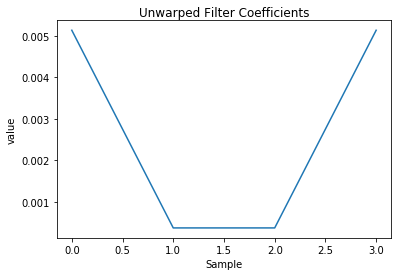

In [2]:
#impulse response:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cunw)
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Unwarped Filter Coefficients')

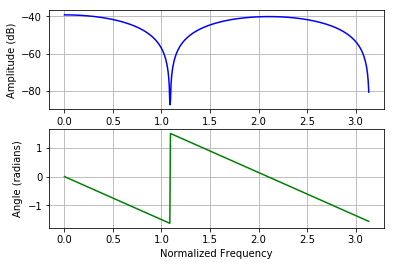

In [3]:
#frequency response:
from freqz import freqz
freqz(cunw, 1)

Here we can see that this is not a good filter. The passband is too wide (up to about 0.15), and there is almost no stopband attenuation (in the range of 0.5 to 0.9). So this filter is probably **useless** for our application.

Now design the FIR low pass flter (4th order), which we then want to frequency warp in the next step, with a warped cutoﬀ frequency. First we have to compute the allpass coefcient „a“ for our allpass flter which results in an approximate Bark warping, according to Julius O. Smith and Jonathan S. Abel, “Bark and ERB Bilinear Transforms,” IEEE Transactions on Speech and
Audio Processing, vol. 7, no. 6, pp. 697 – 708, November 1999:
### $$ a = 1.0674 \cdot \left(\frac{2}{\pi} \cdot arctan(0.6583\cdot f_s)\right)^{0.5} - 0.1916$$

with $f_s$ as the sampling frequency in kHz. Our warped design is then,

In [4]:
from warpingphase import *
import numpy as np
#warping allpass coefficient:
a = 1.0674 * (2 / np.pi * np.arctan(0.6583 * 32)) ** 0.5 - 0.1916
print a

0.859559698991


In [5]:
# with f_s=32 in kHz. from [1]
# The warped cutoff frequency then is:
fcw = -warpingphase(0.05 * np.pi, 0.85956)
print fcw

1.61200904751


In [6]:
# fcw = 1.6120; %in radiants
# filter design:
# cutoff frequency normalized to nyquist:
fcny=fcw/np.pi
print fcny

0.513118416439


In [7]:
c = sp.remez(4, [0, fcny/2.0, fcny/2.0+0.1, 0.5], [1, 0],[1, 100])

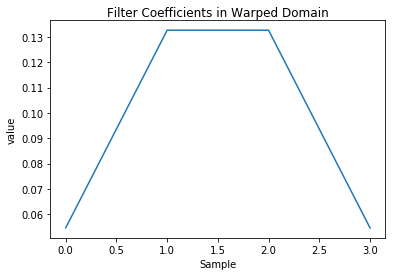

In [8]:
#The resulting Impulse Response:
plt.plot(c);
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Filter Coefficients in Warped Domain')

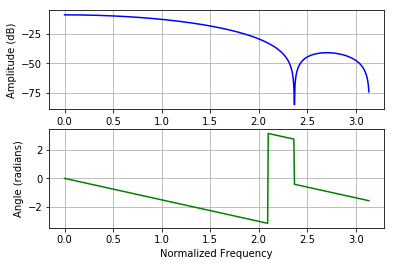

In [9]:
#The resulting Frequency response:
freqz(c,1)

This is the filter we obtain from the $c$ coefficients if we don't replace the delays by allpasses. Here we can see that in the warped domain, we obtain a reasonable low pass flter. In the passband from 0 to somewhat above 0.5 it has a drop of about 10 dB, and in the stopband we obtain about -30 dB attenuation, which is much more than before (it might still not be enough for practical purposes though).

Now we use the same c coefcients, but replace the Delays in the FIR flter with Allpass flters (in this way we go from frequency response $H(z)$ to $H(1/A(z))$:

![WarpedFIlter](wfilt.jpg)

In [10]:
# Warping Allpass filters:
#Numerrator:
B = [-a.conjugate(), 1]
#Denominator:
A = [1, -a]
# Impulse with 80 zeros:
Imp = np.zeros(80)
Imp[0] = 1
x = Imp

# Y1(z)=A(z), Y2(z)=A^2(z),...
# Warped delays:
y1 = sp.lfilter(B,A,x)
y2 = sp.lfilter(B,A,y1)
y3 = sp.lfilter(B,A,y2)

# Output of warped filter with impulse as input:
yout = c[0]*x+c[1]*y1+c[2]*y2+c[3]*y3

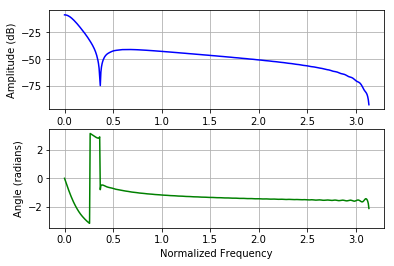

In [11]:
# frequency response:
freqz(yout, 1)

Here we can now see the frequency response of our final warped low pass filter. We can see that again we have a drop of about 10 dB in the passband, now from 0 to 0.05pi, and a stopband attenuation of about 30dB, which is somewhat reasonable.

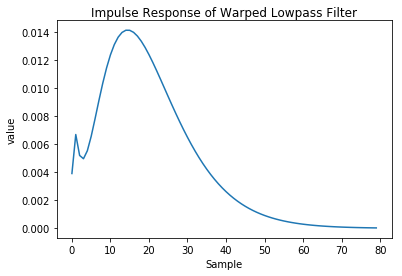

In [12]:
#Impulse response:
plt.plot(yout);
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Impulse Response of Warped Lowpass Filter')

This is the resulting impulse response of our warped flter. What is most obvious is its length. Instead of just 4 samples, as our original unwarped design, it easily reaches80 signifcant samples, and in principle is infnite in extend. This is also what makes it a much better flter than the unwarped original design!